In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import signal
import scipy.io as spio
import pickle
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg
from spiker import *

In [2]:
trainblocks = 200
testblocks = 3000
blocklen = 40
f1 = 10
f2 = 9.5
fH = f1 if (f1>f2) else f2
#Ts = 1.0/(5*fH)
Ts = 1e-6
reps = 3
time = np.linspace(0,int(reps/(fH*Ts)),reps*10*fH)

In [3]:
def gen_data(nblocks,f1,f2,time):
    ip = np.array([])
    op = np.array([])
    for index in range(nblocks):
        if np.random.randint(2):
            block = np.sin(2*np.pi*time/f1)+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(time)))
        else:
            block = np.sin(2*np.pi*time/f2)+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(time)))
    return ip, op

In [4]:
train_ip, train_op = gen_data(trainblocks,f1,f2,time)
test_ip, test_op = gen_data(testblocks,f1,f2,time)
trainLen = np.shape(train_ip)[0]
testLen = np.shape(test_ip)[0]
initLen = 200

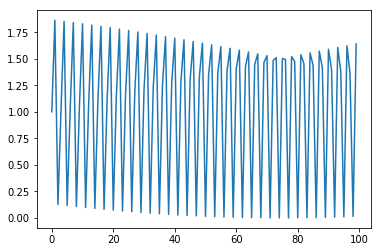

In [9]:
plt.plot(train_ip[:100])

In [6]:
# generate the ESN reservoir
inSize = 1
outSize = 1
resSize = 100
a = 0.3 # leaking rate
random.seed(42)
Win = (random.rand(resSize,1+inSize)-0.5) * 1
W = random.rand(resSize,resSize)-0.5 
# Option 1 - direct scaling (quick&dirty, reservoir-specific):
#W *= 0.135 
# Option 2 - normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('Spectral radius is ', rhoW)
W *= 1.0 / rhoW

# ---------
# Memory allocation
# ---------
print('Allocating memory.')

# allocated memory for the design (collected states) matrix
X = zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = train_op[initLen:trainLen+1] 

# ---------
# TRAINING 
# ---------
print('Running untrained reservoir ...')
# run the reservoir with the data and collect X
x = zeros((resSize,1))
for t in range(trainLen):
    u = train_ip[t]
    data_in = dot( Win, hstack((1,u)))
    data_in.shape = (resSize,1)
    #x = (1-a)*x + a*tanh( data_in + dot( W, x ) )
    x = np.maximum(0,(1-a)*x + a*tanh( data_in + dot( W, x )))
    if t >= initLen:
        X[:,t-initLen] = vstack((1,u,x))[:,0]

# ---------
# Ridge regression
# ---------
print('Fitting Wout using Ridge regression ... ')
reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + reg*eye(1+inSize+resSize) ) )
print('Done.')

Computing spectral radius...
Spectral radius is  3.161157556795834
Allocating memory.
Running untrained reservoir ...
Fitting Wout using Ridge regression ... 
Done.


In [7]:
# -----------
# Fitting performance using Training set
# -----------
# run the reservoir with the data and collect X
train_yo = np.zeros_like(train_op)
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = train_ip[t]
    data_in = np.dot( Win, hstack((1,u)))
    data_in.shape = (resSize,1)
    #x = (1-a)*x + a*np.tanh( data_in + np.dot( W, x ) )
    x = np.maximum(0,(1-a)*x + a*tanh( data_in + dot( W, x )))
    res = np.dot( Wout, np.vstack((1,u,x)) )
    train_yo[t] = res

In [8]:
# -----------
# Generalization using Test Set
# -----------
# run the reservoir with the data and collect X
test_yo = np.zeros_like(test_op)
x = zeros((resSize,1))
for t in range(testLen):
    u = test_ip[t]
    data_in = dot( Win, hstack((1,u)))
    data_in.shape = (resSize,1)
    #x = (1-a)*x + a*tanh( data_in + dot( W, x ) )
    x = np.maximum(0,(1-a)*x + a*tanh( data_in + dot( W, x )))
    res = dot( Wout, vstack((1,u,x)) )
    test_yo[t] = res

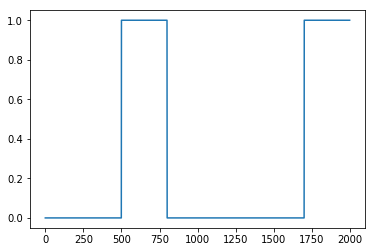

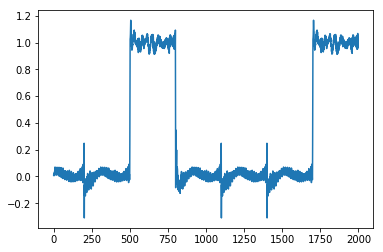

In [9]:
start = -2000
plt.plot(train_op[start:-1])
plt.figure()
plt.plot(train_yo[start:-1])

In [10]:
file_Name = "reservoir"
fileObject = open(file_Name,'wb') 
pickle.dump((Win,Wout,W),fileObject)   
fileObject.close()

Total nodes # =  105
Input nodes # =  2
Input neuron # =  2
Reservoir neuron # =  100
Output neuron # =  1


/home/manu/anaconda3/envs/keras/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


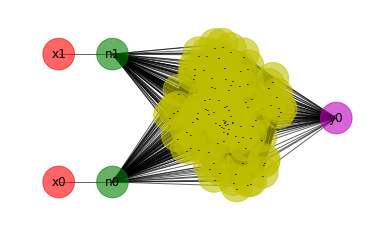

In [11]:
G,W_full = create_graph(W,Win,Wout)